100%|██████████| 100/100 [01:28<00:00,  1.13it/s, epoch=99, loss=67.7, val_loss=37.3]


Training   loss: 37.31486780102514
Validation loss: 38.29930996497472
24 (1, 4, 5) [ 1.4338747  26.727262    0.20693938  0.75414056] [nan nan nan nan]
32 (1, 4, 5) [ 1.5359704  34.355453    0.25447157  0.7544478 ] [nan nan nan nan]
40 (1, 4, 5) [ 1.646117   41.32034     0.29825595  0.75547004] [ 1.88448402 30.13        0.355       0.78      ]
48 (1, 4, 7) [ 1.7644136 48.278515   0.3325071  0.7931503] [ 1.75648396 47.2         0.338       0.865     ]
56 (1, 5, 7) [ 1.6038345  59.478695    0.38100863  0.7822895 ] [nan nan nan nan]
64 (1, 5, 8) [ 1.6937623  65.41633     0.41081896  0.8034146 ] [ 1.57333584 64.73        0.4         0.885     ]
72 (1, 5, 8) [ 1.802365  69.83672    0.4318925  0.8114547] [ 1.80919071 69.69571429  0.46342857  0.83371429]
80 (1, 6, 6) [ 1.6887625  79.80753     0.47500515  0.78454554] [ 1.54866458 79.73666667  0.533       0.79333333]
88 (1, 7, 5) [ 1.5832258  88.14127     0.53164303  0.7532233 ] [ 1.30081279 88.          0.495       0.761     ]
96 (1, 7, 6) [ 1.

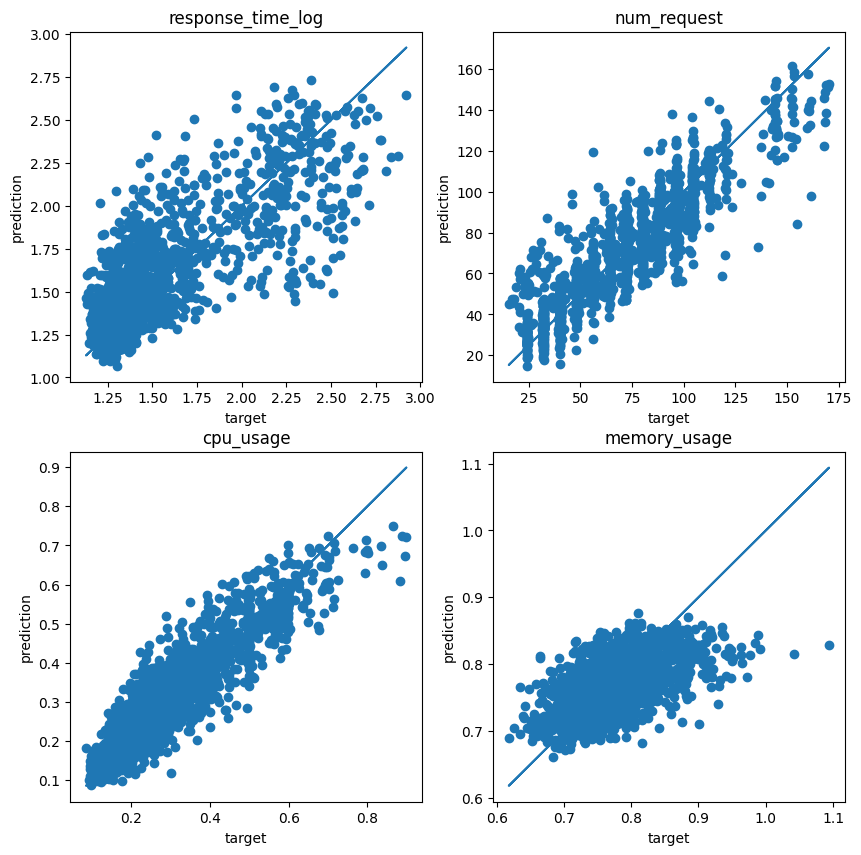

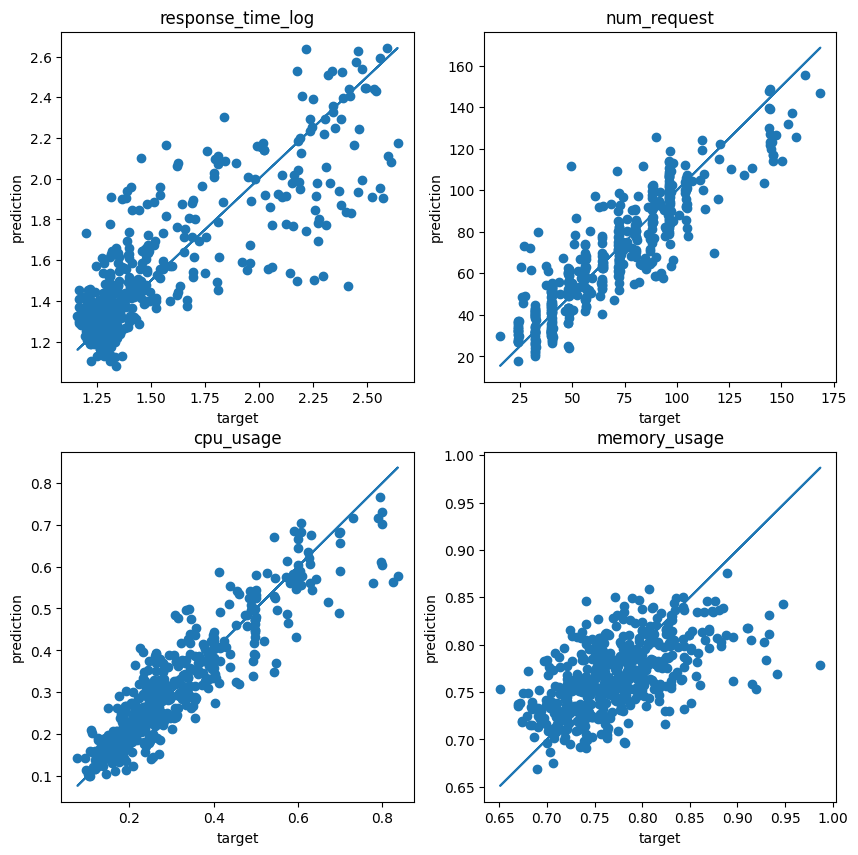

In [1]:
#%%
import pandas as pd
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import one_hot
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


def read_data() -> pd.DataFrame:
    df = pd.read_csv('server_client_v4/output_300_1.csv')
    for i in ['2','3','4']:
        df_tmp = pd.read_csv(f'server_client_v4/output_300_{i}.csv')
        df = pd.concat([df, df_tmp])

    for i in ['1','2','3']:
        df_tmp = pd.read_csv(f'server_client_v4/output_browse_300_data_{i}.csv')
        df = pd.concat([df, df_tmp])


    df = df[(df['memory_usage'] > 0) & (df['cpu_usage'] > 0)]
    df['response_time_log'] = np.log10(df['response_time'])

    #df=(df-df.mean())/df.std()
    return df

class MetricEstimator(nn.Module):
    def __init__(self, in_features: int, out_features: int, 
                 loss_fn=torch.nn.functional.mse_loss):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.loss_fn = loss_fn

        layer_size = [40,50]
        self.input_layer = nn.Sequential(
            nn.BatchNorm1d(num_features=in_features)
        )

        self.layer_0 = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=layer_size[0]),
            nn.GELU(),
            nn.BatchNorm1d(num_features=layer_size[0]),
        )

        self.layer_1 = nn.Sequential(
            nn.Linear(in_features=layer_size[0], out_features=layer_size[1]),
            nn.GELU(),
            nn.BatchNorm1d(num_features=layer_size[1]),
        )

        self.output_layer = nn.Sequential(
            nn.Linear(in_features=layer_size[-1],out_features=out_features),
        )
        


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.input_layer(x)
        out = self.layer_0(out)
        out = self.layer_1(out)
        out = self.output_layer(out)
        return out
    

    def predict(self, dataloader):
        with torch.no_grad():
            predictions = torch.empty(0, self.out_features)
            targets = torch.empty(predictions.shape)
            for x, y in dataloader:
                y_pred = self.forward(x)
                predictions = torch.cat([predictions, y_pred], dim=0)
                targets = torch.cat([targets, y], dim=0)
            return predictions, targets
    
    def evaluate(self, dataloader):
        with torch.no_grad():
            avg_loss = 0
            for x, y in dataloader:
                y_pred = self.forward(x)
                loss = self.loss_fn(y_pred, y)
                avg_loss += loss.item()
            avg_loss = avg_loss / len(dataloader) 
            return avg_loss

class OfflineDataset(Dataset):
    def __init__(self):
        super().__init__()
        self.df = read_data()
        self.replica_set = pd.unique(self.df['replica'])
        self.cpu_set = pd.unique(self.df['cpu'])
        self.heap_set = pd.unique(self.df['heap'])
        self.cpu_min = self.df['cpu'].min()
        self.heap_min = self.df['heap'].min()
        self.replica_min = self.df['replica'].min()

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Related to actions
        x_1 = torch.tensor([row['replica']])
        x_2 = torch.tensor([row['cpu']])
        x_3 = torch.tensor([row['heap']])
        
        # Related to incoming load
        x_4 = torch.tensor([row['expected_tps']])
        
        # Target metrics
        y_1 = torch.tensor([row['response_time_log']])
        y_2 = torch.tensor([row['num_request']])
        y_3 = torch.tensor([row['cpu_usage']])
        y_4 = torch.tensor([row['memory_usage']])

        input = torch.concat([x_1, x_2, x_3, x_4]).to(torch.float)
        output = torch.concat([y_1, y_2, y_3, y_4]).to(torch.float)
        
        return input, output

    def getshapes(self):
        x, y = self.__getitem__(0)
        input_size = (len(self.df), len(x))
        output_size = (len(self.df), len(y))
        return input_size, output_size
    
    def getoutputnames(self):
        return ['response_time_log', 'num_request','cpu_usage','memory_usage']


def mape_loss_fn(output, target):
    return torch.mean(torch.abs((target - output) / target))

seed = 42
trn_ratio = 0.8
batch_size_trn = 16
batch_size_val = 16
max_epoch = 100
loss_fn = torch.nn.functional.mse_loss

torch.manual_seed(seed)

ds = OfflineDataset()
trn_size = int(len(ds)*trn_ratio)
val_size = len(ds) - trn_size
ds_trn, ds_val = torch.utils.data.random_split(ds, [trn_size, val_size])
dl_trn = DataLoader(ds_trn, batch_size=batch_size_trn, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_size_val, shuffle=True)

x, y = ds.getshapes()
_, in_features = x
_, out_features = y

metric_estimator = MetricEstimator(in_features=in_features, out_features=out_features, loss_fn=loss_fn)
optim = torch.optim.Adam(metric_estimator.parameters())


epochbar = tqdm(range(max_epoch))
for ep in epochbar:
    metric_estimator.train()
    pbar = tqdm(dl_trn)
    for x, y in pbar:
        optim.zero_grad()
        y_pred = metric_estimator(x)
        loss = loss_fn(y_pred, y)
        pbar.set_postfix(loss=loss.item())
        loss.backward()
        optim.step()

    val_loss = metric_estimator.evaluate(dl_val)
    epochbar.set_postfix(epoch=ep,loss=loss.item(),val_loss=val_loss)

pred_trn, target_trn = metric_estimator.predict(dl_trn)
pred_val, target_val = metric_estimator.predict(dl_val)

def scatter(pred, target):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
    for ax, i, title in zip(axes.flatten(), range(4), ds.getoutputnames()):
        ax.scatter(target[:,i], pred[:,i])
        ax.plot(target[:,i], target[:,i])
        # if title == 'response_time':
            # ax.set_xscale('log')
            # ax.set_yscale('log')
        ax.set_xlabel('target')
        ax.set_ylabel('prediction')
        ax.set_title(title)

scatter(pred_trn, target_trn)
scatter(pred_val, target_val)


trn_loss = metric_estimator.evaluate(dl_trn)
val_loss = metric_estimator.evaluate(dl_val)
print(f'Training   loss: {trn_loss}')
print(f'Validation loss: {val_loss}')


metric_estimator.eval()
df = read_data()

def reward(response_time, num_request, cpu, memory, expected_tps, cpu_limit, memory_limit):
    #print(response_time, num_request, cpu, memory, expected_tps, cpu_limit, memory_limit)
    speed = 1 if response_time < 20 else 20/response_time
    performance = 0.5 * min(num_request/expected_tps, 1) + 0.5 * speed 
    utilization = 0.5 * min(cpu / (cpu_limit / 10), 1) + 0.5 * min(memory / (memory_limit / 10), 1)
    #print(performance, utilization)
    r = 0.8 * performance  + 0.2 * utilization
    return r


def policy(expected_tps):
    max_reward = -1

    for replica in range(1,10): #pd.unique(df['replica']):
        for cpu in range(1,10): #pd.unique(df['cpu']):
            for heap in range(1,10): #pd.unique(df['heap']):
                state = torch.from_numpy(np.array([replica, cpu, heap, expected_tps])).to(torch.float)
                estimated_metrics = metric_estimator(state[None, :]).squeeze()
                r = reward(estimated_metrics[0], estimated_metrics[1], estimated_metrics[2], estimated_metrics[3], expected_tps, cpu, heap)
                if r > max_reward:
                    max_reward = r
                    best_action = (replica, cpu, heap)
                    best_metrics = estimated_metrics

                    df_avg = df.query(f'expected_tps == {expected_tps} and replica=={replica} and cpu == {cpu} and heap == {heap}').mean()
                    real_metrics = df_avg[ds.getoutputnames()].to_numpy()

    return best_action, best_metrics, real_metrics


for tps in sorted(pd.unique(df['expected_tps'])):
    chosen_action, best_metrics, real_metrics = policy(tps)
    print(tps, chosen_action, best_metrics.detach().numpy(), real_metrics)




